# SEAM Phase 1 Data Modelling

In this notebook we do foward modelling of total seismic data (with free surface) and also of only primaries (with absorbent surface), as a means to obtain a true multiples model which we'll use as ground truth for the next notebooks. To avoid having ghosts on the multiples, we will model primaries with ghosts and then subtract from the total data.

#### Import libraries

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import time
import segyio
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import RegularGridInterpolator

from adasubtraction.waveeqmod import Acoustic2DDevito

# Velocity model
For this example we are going to utilize the SEAM phase I 2D Vp dataset, which consists of a cross-section at North=23,900 from the 3D Seam phase I model. The section is 35000 m long and depth extends to 15000 m and simulates a body of salt.

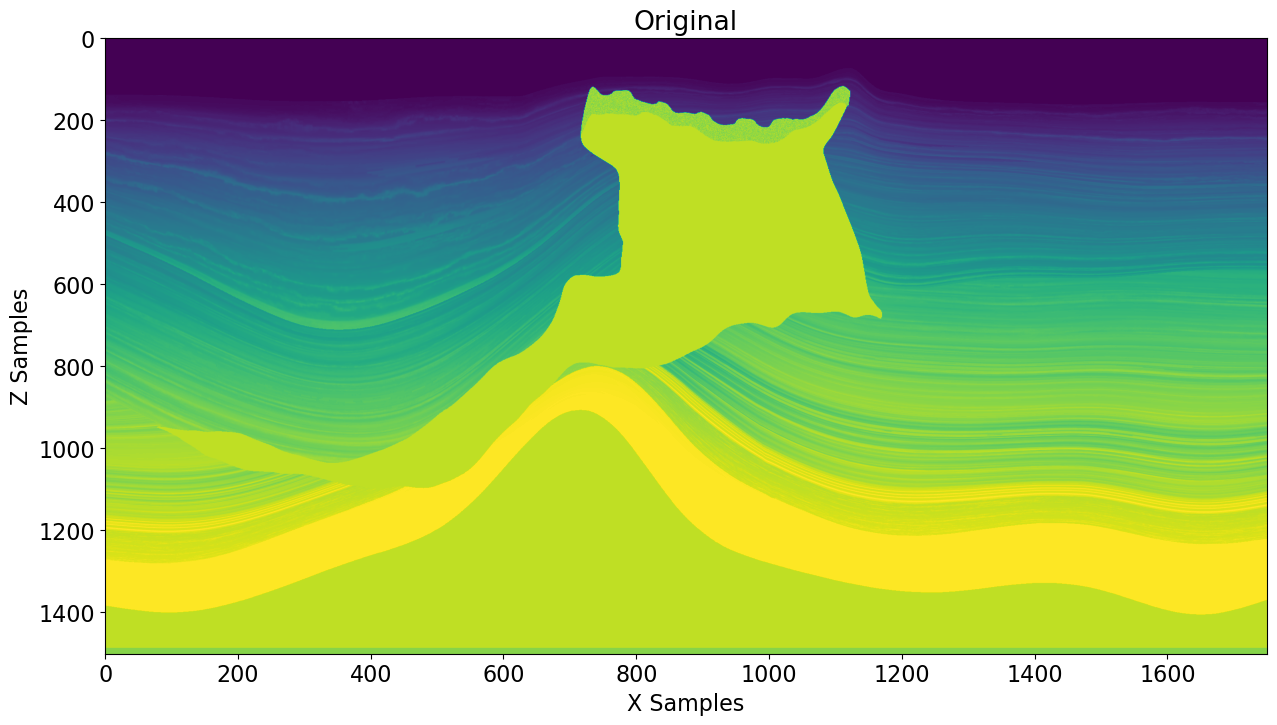

In [2]:
# Velocity
vp = segyio.open('../data/SEAM_Vp_Elastic_N23900.sgy',ignore_geometry=True)
vp2d = segyio.collect(vp.trace[:]).T

# Original velocity model
plt.figure(figsize=(15, 8))
plt.imshow(vp2d)
plt.axis('tight')
plt.title('Original')
plt.ylabel('Z Samples')
plt.xlabel('X Samples')

plt.show()

In order to get only surface-related multiples in the recordings, we will truncate the section to 6400 m long and 6500 m depth at the upper left corner.

## 1) Total data

In [2]:
# Dimensions
nz, nx = 650, 320 # vp2d.shape[0], vp2d.shape[1] (truncated)
dz, dx = 10, 20 # original sampling

# Velocity
vp = segyio.open('../data/SEAM_Vp_Elastic_N23900.sgy',ignore_geometry=True)
vp2d = segyio.collect(vp.trace[:]).T

vp2d = vp2d[2:nz,:nx] # create model from 20m below the actual free surface
vp2d.shape

(648, 320)

We leave 50m of water column out of the velocity model because we'll need to add it for posterior ghosts modelling. Now we'll generate an uniformly spaced grid.

In [3]:
# Resample on 10 x 10 m grid
x = np.arange(nx) * dx
z = np.arange(nz-2) * dz  # take away 2 samples

xint = np.arange(x[0], x[-1], 10) 
zint = np.arange(z[0], z[-1], 10)  

nxint, nzint = len(xint), len(zint)

X, Z = np.meshgrid(xint, zint, indexing='ij')  # create empty grid
XZ = np.vstack((X.ravel(), Z.ravel())).T

# Interpolate original spaced model
interpolator = RegularGridInterpolator((x,z), vp2d.T, bounds_error=False, fill_value=0)
# Reshape it 
vp2dinterp = interpolator(XZ).reshape(nxint, nzint).T
vp2dinterp.shape

(647, 638)

As a way of getting a stronger surface related multiple, we scale the impedance difference between the seafloor and the water column, thus increasing the reflection coefficient.

In [5]:
# Water velocity = 1490 m/s
water_vel = vp2dinterp[0,0]
vp2dinterp[vp2dinterp<=water_vel] = 0
vp2dinterp = vp2dinterp * 1.4  # scaling 
vp2dinterp[vp2dinterp==0] = water_vel

Plot the velocity model.

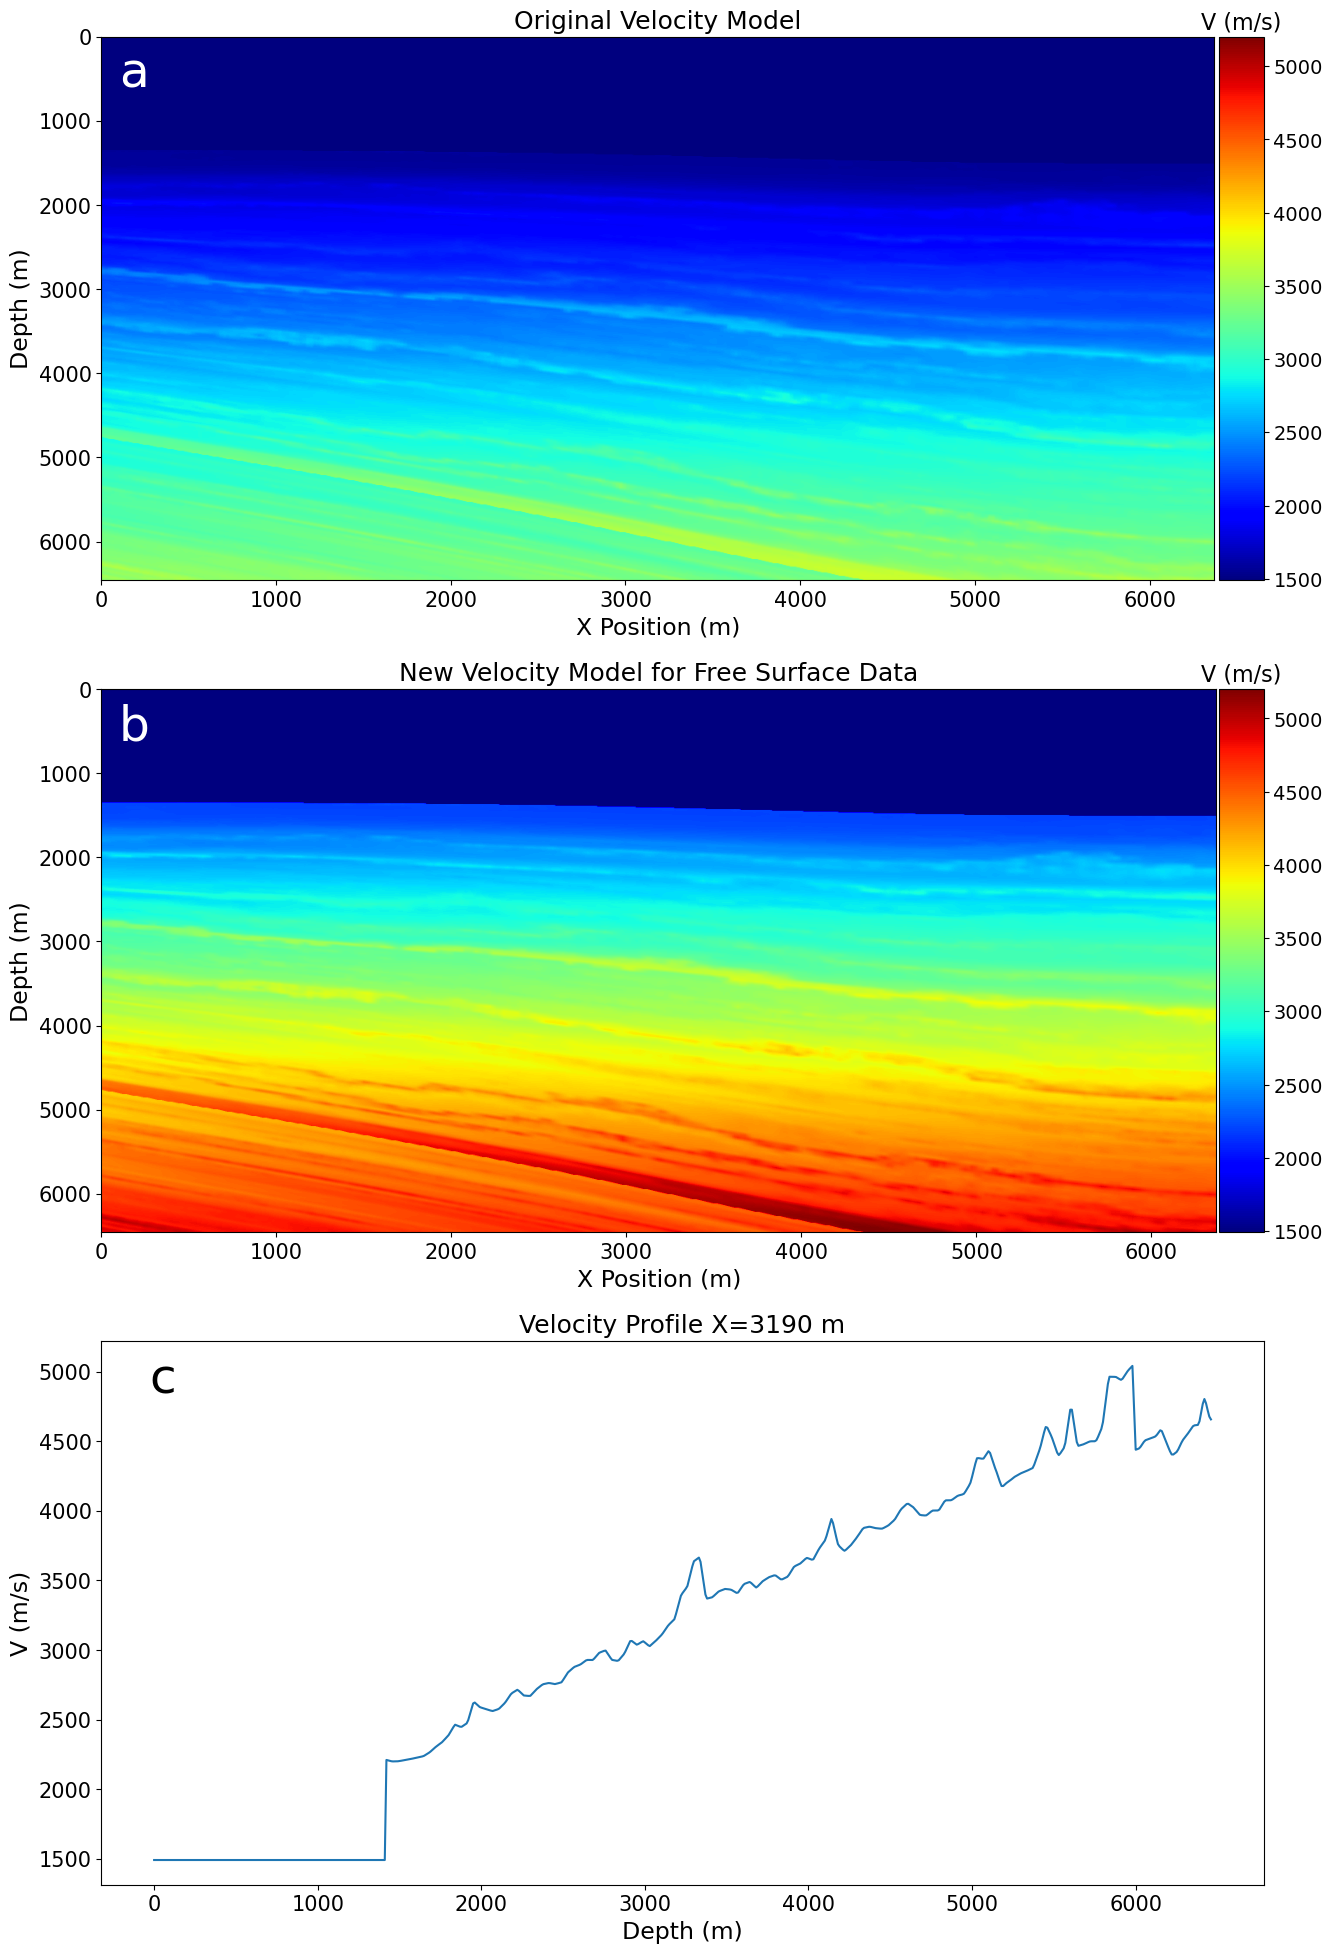

In [6]:
# Create figure
fig, axs = plt.subplots(3,1, figsize=(15, 24))

# Original velocity model
im1 = axs[0].imshow(vp2d, cmap='jet', vmax=vp2dinterp.max(), extent=(xint[0], xint[-1], zint[-1], zint[0]))
axs[0].axis('tight')
axs[0].set_title('Original Velocity Model', fontsize=18)
axs[0].set_ylabel('Depth (m)', fontsize=17)
axs[0].set_xlabel('X Position (m)', fontsize=17)
axs[0].tick_params(axis='x', labelsize=15)
axs[0].tick_params(axis='y', labelsize=15)
axs[0].text(100, 600, 'a', fontsize=35, c='white')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='4%', pad=0.05)
cax.set_title('V (m/s)', fontsize=16)
cax.tick_params(labelsize=14)
fig.colorbar(im1, cax=cax, orientation='vertical')

# Interpolated and scale velocity model
im1 = axs[1].imshow(vp2dinterp, cmap='jet', extent=(xint[0], xint[-1], zint[-1], zint[0]))
axs[1].axis('tight')
axs[1].set_title('New Velocity Model for Free Surface Data', fontsize=18)
axs[1].set_ylabel('Depth (m)', fontsize=17)
axs[1].set_xlabel('X Position (m)', fontsize=17)
axs[1].tick_params(axis='x', labelsize=15)
axs[1].tick_params(axis='y', labelsize=15)
axs[1].text(100, 600, 'b', fontsize=35, c='white')


divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='4%', pad=0.03)
cax.set_title('V (m/s)', fontsize=16)
cax.tick_params(labelsize=14)
fig.colorbar(im1, cax=cax, orientation='vertical')

# Velocity Profile
axs[2].plot(zint, vp2dinterp[:, nxint//2])
axs[2].set_title(f'Velocity Profile X={nxint//2*10} m', fontsize=18)
axs[2].set_xlabel('Depth (m)', fontsize=17)
axs[2].set_ylabel('V (m/s)', fontsize=17)
axs[2].tick_params(axis='x', labelsize=15)
axs[2].tick_params(axis='y', labelsize=15)
axs[2].text(-30, 4850, 'c', fontsize=35, c='black')

plt.show()

All sources and receivers will be placed at the same positions for later SRME Multiple Prediction, at 5m depth.

In [4]:
# Geometry arrange
nsrc = nxint # number of sources
nrec = nxint # number of receivers
shape = (nxint, nzint)
spacing = (10, 10)
origin = (0, 0) 

# Modelling parameters
nbl = 300 # number of boundary layers around the domain
space_order = 6 # space order of the simulation
t0 = 0 # initial time
tn = 8000 # total simulation time (ms)
dt = 4 # time sampling (ms)
f0 = 10 # source peak freq (1/ms)

# Free surface to generate data with multiples
fs = True

In [8]:
# Create finite-diference acoustic modelling class with Devito
awe = Acoustic2DDevito()

# Create model
awe.create_model(shape, origin, spacing, vp2dinterp.T, space_order, nbl=nbl, fs=fs)
awe.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=5,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=5,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

print(awe.geometry.dt)

Operator `initdamp` ran in 0.01 s


1.022


Given that our sources and receivers are 25m below the surface our total data has ghosts.

In [9]:
# Choose middle shot
isrc = nsrc//2
data, _, _ = awe.solve_one_shot(isrc, dt=dt)

Operator `Forward` ran in 10.44 s


Plot the source signature to find out how many samples you need to remove in order to compensate the data for the phase of the wavelet, since it's not centered on zero.

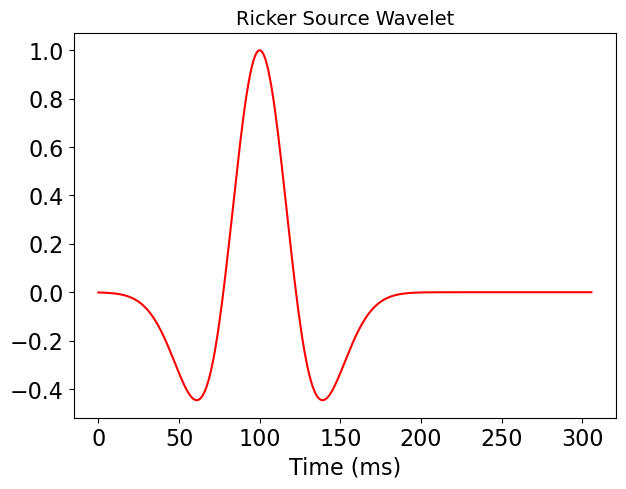

In [10]:
# Plot the source wavelet

plt.figure(figsize=(7, 5))
plt.title('Ricker Source Wavelet', fontsize=14)
plt.plot(awe.geometry.time_axis.time_values[:300], awe.geometry.src.data[:300,0], c='r')
plt.xlabel('Time (ms)')
plt.show()

In [11]:
sm = np.argmax(awe.geometry.src.data[:300,0])*awe.geometry.dt/dt
print(f'The number of samples to remove from the data is {round(sm)}')

The number of samples to remove from the data is 25


We also remove the last sample to avoid artifacts at the boundary. The same slicing will be done on the direct wave recordings and primaries to avoid size mismatches.

In [12]:
# Remove samples

data = data.data[25:-1]

#### - Total Data Direct wave
Now also model the direct wave in order to subtract it from the shots and get rid of noisy data.

In [13]:
vp_dw = water_vel*np.ones_like(vp2dinterp)

# Force engine to have the same time sampling as the previous vel. model
vp_dw[-1, -1] = np.max(vp2dinterp)

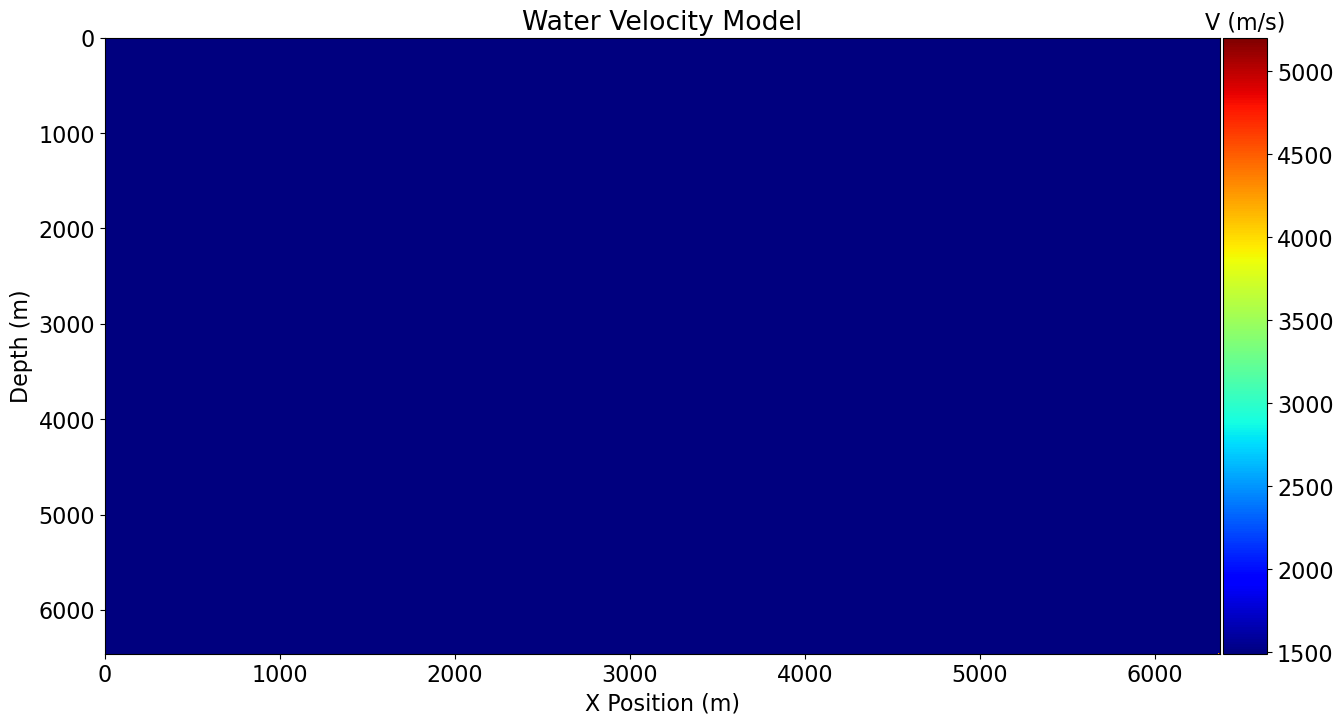

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
im = ax.imshow(vp_dw, cmap='jet', extent=(xint[0], xint[-1], zint[-1], zint[0]))
ax.axis('tight')
ax.set_title('Water Velocity Model')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('X Position (m)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.03)
cax.set_title('V (m/s)', fontsize=16)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [15]:
# Create finite-diference acoustic modelling class with Devito
awe_dw = Acoustic2DDevito()

# Create model
awe_dw.create_model(shape, origin, spacing, vp_dw.T, space_order, nbl=nbl, fs=fs)
awe_dw.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=5,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=5,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

print(awe.geometry.dt) # check if it is the same 

Operator `initdamp` ran in 0.01 s


1.022


In [16]:
# Choose middle shot
isrc = nsrc//2
dw, _, _ = awe_dw.solve_one_shot(isrc, dt=dt)

Operator `Forward` ran in 9.52 s


In [17]:
# Remove samples

dw = dw.data[25:-1]     # last sample is also removed to eliminate bottom artifacts

In [18]:
# Subtract the direct wave from the full shot
data_nodw = data - dw

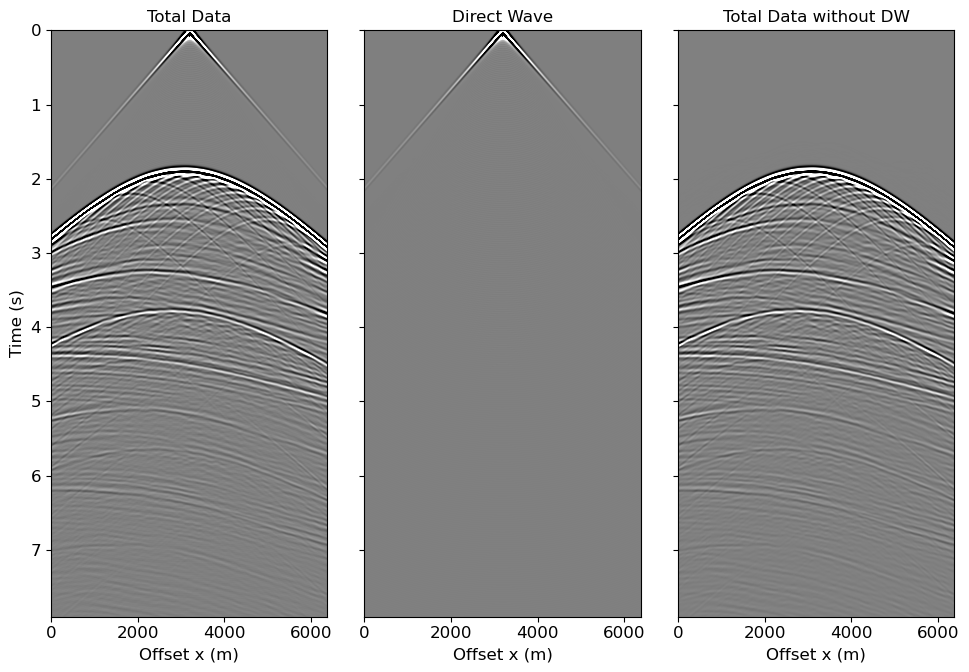

In [19]:
nt = data.shape[0]
nr = data.shape[1]
dt =  0.004
dx = 10

# Visualize data
t0 = 0
t1 = t0 + (nt - 1)*dt
xmin = 0
xmax = nr*dx

vmax = 1e-2 
vmin = -vmax

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(data, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title('Total Data',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[1].imshow(dw, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title('Direct Wave',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)
axs[2].imshow(data_nodw, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title('Total Data without DW',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=12)
axs[2].tick_params(axis='x', labelsize=12)

plt.tight_layout()

## 2) Primaries with ghosts
To model primaries with ghosts, first we pad the data with enough water layers (the previously removed 50m), take away the free surface and then put mirror sources and receivers with respect to a datum (see de Jonge, 2023). Our sources and receivers are now located at a depth of 75m (50+25) and the datum is at 50m depth (previous FS). The method works as follows:

p = p1 + p4 - p2 - p3

where

p1 -> scs and rcs placed at original depth (25m - 25m)

p2 -> original scs and mirror rcs (25m - 15m)

p3 -> mirror scs and original rcs (15m - 25m)

p4 -> mirror scs and mirror rcs (15m - 15m)

| <img src="../figures/prims_ghosts.png" alt> |
|:--:| 
| *(a) Primary and ghosts arrivals shown as rays from the source to a receiver. (b) Primary and ghosts shown in the time domain for one receiver. Modified from De Jonge T. (2023)* |

In [3]:
# Dimensions
nz, nx = 650, 320 # vp2d.shape[0], vp2d.shape[1] (truncated)
dz, dx = 10, 20

# Velocity
vp = segyio.open('../data/SEAM_Vp_Elastic_N23900.sgy',ignore_geometry=True)
vp2d = segyio.collect(vp.trace[:]).T

vp2d = vp2d[:nz,:nx]     # this time import all samples, giving 20 m more of water column

# Resample on 10 x 10 m grid
x = np.arange(nx) * dx
z = np.arange(nz) * dz
xint = np.arange(x[0], x[-1], 10)
zint = np.arange(z[0], z[-1], 10)
nxint, nzint = len(xint), len(zint)
X, Z = np.meshgrid(xint, zint, indexing='ij')
XZ = np.vstack((X.ravel(), Z.ravel())).T

vp2dinterp = np.zeros(nxint*nzint, dtype=np.float32)
interpolator = RegularGridInterpolator((x,z), vp2d.T, bounds_error=False, fill_value=0)
vp2dinterp = interpolator(XZ).reshape(nxint, nzint).T
vp2dinterp.shape

(649, 638)

In [7]:
# Reescale velocity again

vp2dinterp[vp2dinterp<=1490] = 0
vp2dinterp = vp2dinterp * 1.4
vp2dinterp[vp2dinterp==0] = 1490

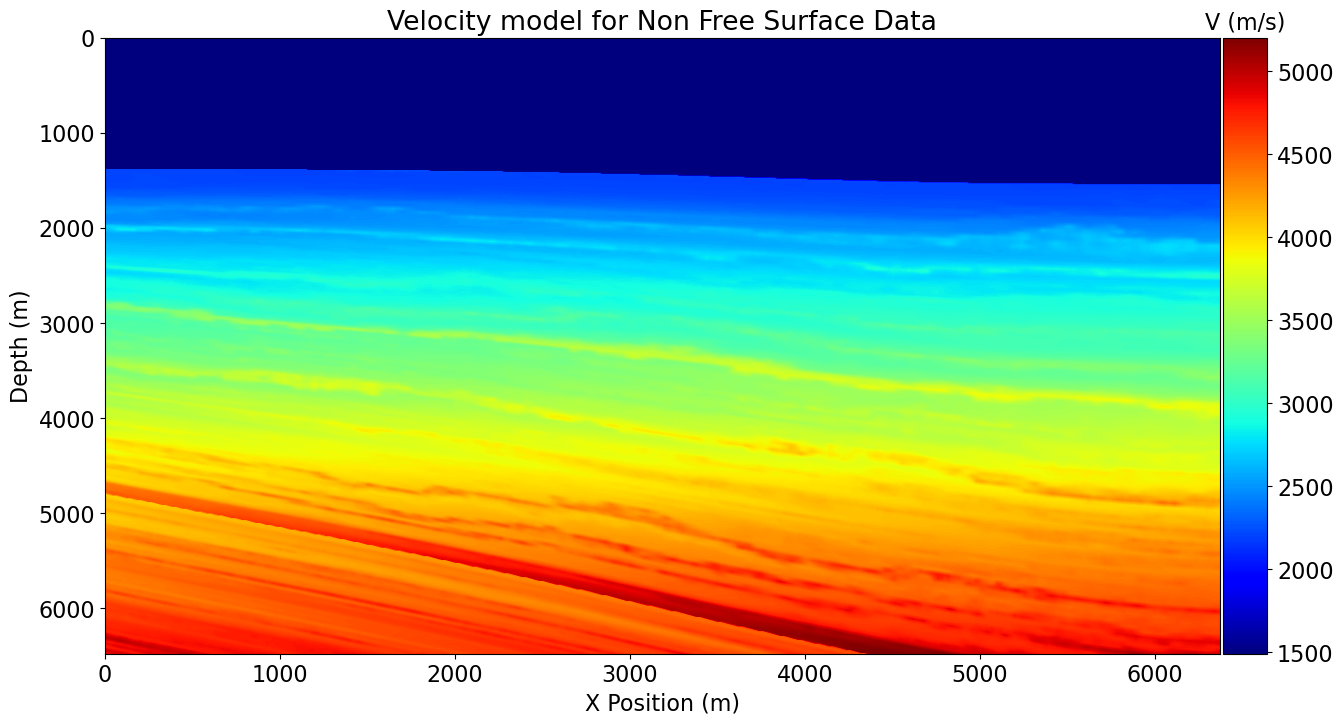

In [8]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
im = ax.imshow(vp2dinterp, cmap='jet', extent=(xint[0], xint[-1], zint[-1], zint[0]))
ax.axis('tight')
ax.set_title("Velocity model for Non Free Surface Data")
ax.set_ylabel('Depth (m)')
ax.set_xlabel('X Position (m)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.03)
cax.set_title('V (m/s)', fontsize=16)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [9]:
# Model parameter change
shape = (nxint, nzint)

# Take away fs to avoid surface related multiples
fs = False

In [10]:
# Compute p1 - primary reflection

awe_1 = Acoustic2DDevito()

awe_1.create_model(shape, origin, spacing, vp2dinterp.T, space_order, nbl=nbl, fs=fs)
awe_1.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=25,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=25,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

isrc = nsrc//2 # middle shot
p1, _, _ = awe_1.solve_one_shot(isrc, dt=dt)

Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 12.43 s


In [11]:
# Compute p2 - receiver ghost

awe_2 = Acoustic2DDevito()

awe_2.create_model(shape, origin, spacing, vp2dinterp.T, space_order, nbl=nbl, fs=fs)
awe_2.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=25,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=15,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

p2, _, _ = awe_2.solve_one_shot(isrc, dt=dt)

Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 12.20 s


In [12]:
# Compute p3 -> source ghost

awe_3 = Acoustic2DDevito()

awe_3.create_model(shape, origin, spacing, vp2dinterp.T, space_order, nbl=nbl, fs=fs)
awe_3.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=15,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=25,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

p3, _, _ = awe_3.solve_one_shot(isrc, dt=dt)

Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 12.03 s


In [13]:
# Compute p4 -> source-receiver ghost

awe_4 = Acoustic2DDevito()

awe_4.create_model(shape, origin, spacing, vp2dinterp.T, space_order, nbl=nbl, fs=fs)
awe_4.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=15,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=15,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

p4, _, _ = awe_4.solve_one_shot(isrc, dt=dt)

Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 12.66 s


In [14]:
# Remove samples

p1 = p1.data[25:-1]
p2 = p2.data[25:-1]
p3 = p3.data[25:-1]
p4 = p4.data[25:-1]

In [15]:
# Get primaries with ghosts
p = p1 + p4 - p2 - p3

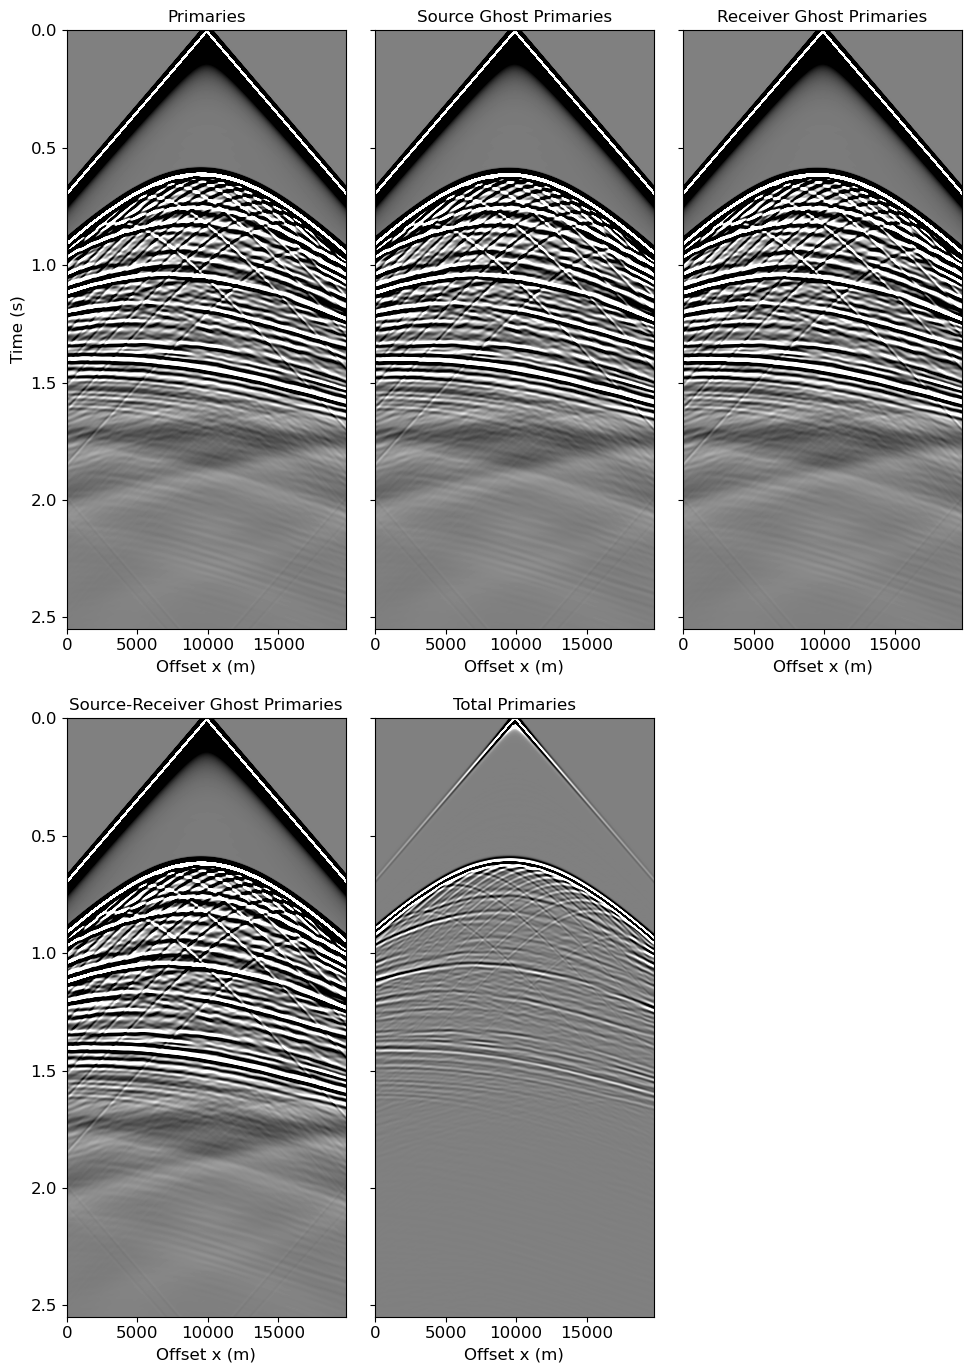

In [16]:
nt = data.shape[0]
nr = data.shape[1]
dt = 0.004
dx = 10

# Visualize data
t0 = 0
t1 = t0 + (nt - 1)*dt
xmin = 0
xmax = nr*dx

vmax = 1e-2 
vmin = -vmax

fig, axs = plt.subplots(2, 3, figsize=(10,14),sharey=True)

axs[0][0].imshow(p1, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0][0].set_title('Primaries',fontsize=12)
axs[0][0].set_xlabel('Offset x (m)',fontsize=12)
axs[0][0].set_ylabel('Time (s)',fontsize=12)
axs[0][0].tick_params(axis='x', labelsize=12)
axs[0][0].tick_params(axis='y', labelsize=12)

axs[0][1].imshow(p2, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0][1].set_title('Source Ghost Primaries',fontsize=12)
axs[0][1].set_xlabel('Offset x (m)',fontsize=12)
axs[0][1].tick_params(axis='x', labelsize=12)

axs[0][2].imshow(p3, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0][2].set_title('Receiver Ghost Primaries',fontsize=12)
axs[0][2].set_xlabel('Offset x (m)',fontsize=12)
axs[0][2].tick_params(axis='x', labelsize=12)

axs[1][0].imshow(p4, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1][0].set_title('Source-Receiver Ghost Primaries',fontsize=12)
axs[1][0].set_xlabel('Offset x (m)',fontsize=12)
axs[1][0].tick_params(axis='y', labelsize=12)
axs[1][0].tick_params(axis='x', labelsize=12)

axs[1][1].imshow(p, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1][1].set_title('Total Primaries',fontsize=12)
axs[1][1].set_xlabel('Offset x (m)',fontsize=12)
axs[1][1].tick_params(axis='x', labelsize=12)
axs[1][2].axis("off")

plt.tight_layout()

#### - Primaries Direct Wave
We do the same procedure as before, but creating a direct wave for each reflection and summing them up.

In [5]:
vp_dw = vp2dinterp[0,0]*np.ones_like(vp2dinterp)

# Force engine to have the same time sampling as the previous vel. model
vp_dw[-1, -1] = np.max(vp2dinterp)

In [7]:
# Compute p1 / primary reflection
awe_dw1 = Acoustic2DDevito()

awe_dw1.create_model(shape, origin, spacing, vp_dw.T, space_order, nbl=nbl, fs=fs)
awe_dw1.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=25,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=25,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

isrc = nsrc//2 # middle shot
p1_dw, _, _ = awe_dw1.solve_one_shot(isrc, dt=dt)

Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 9.19 s


In [8]:
# Compute p2 / receiver ghost 
awe_dw2 = Acoustic2DDevito()

awe_dw2.create_model(shape, origin, spacing, vp_dw.T, space_order, nbl=nbl, fs=fs)
awe_dw2.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=15,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=25,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

p2_dw, _, _ = awe_dw2.solve_one_shot(isrc, dt=dt)

Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 9.22 s


In [9]:
# Compute p3 / source ghost
awe_dw3 = Acoustic2DDevito()

awe_dw3.create_model(shape, origin, spacing, vp_dw.T, space_order, nbl=nbl, fs=fs)
awe_dw3.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=25,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=15,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

p3_dw, _, _ = awe_dw3.solve_one_shot(isrc, dt=dt)

Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 9.44 s


In [10]:
# Compute p4 / source-receiver ghost
awe_dw4 = Acoustic2DDevito()

awe_dw4.create_model(shape, origin, spacing, vp_dw.T, space_order, nbl=nbl, fs=fs)
awe_dw4.create_geometry(src_x=np.arange(0, nsrc) * spacing[0],
                    src_z=15,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=15,
                    t0=t0, tn=tn, src_type='Ricker', f0=f0)

p4_dw, _, _ = awe_dw4.solve_one_shot(isrc, dt=dt)

Operator `initdamp` ran in 0.01 s
Operator `Forward` ran in 9.29 s


In [11]:
# Remove samples

p1_dw = p1_dw.data[25:-1]
p2_dw = p3_dw.data[25:-1]
p3_dw = p3_dw.data[25:-1]
p4_dw = p4_dw.data[25:-1]

In [13]:
# Get primaries with ghosts
p_dw = p1_dw + p4_dw - p2_dw - p3_dw

# Primaries without direct wave
p_nodw = p - p_dw

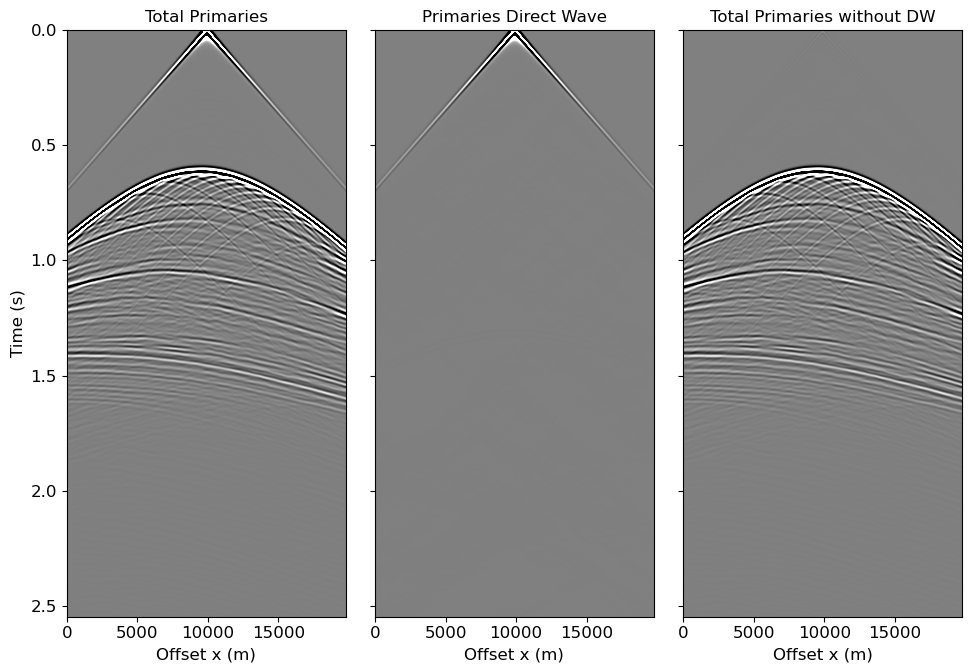

In [15]:
# Visualize data
t0 = 0
t1 = t0 + (nt - 1)*dt
xmin = 0
xmax = nr*dx

vmax = 1e-2 
vmin = -vmax

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(p, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title('Total Primaries',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[1].imshow(p_dw, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title('Primaries Direct Wave',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)
axs[2].imshow(p_nodw, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title('Total Primaries without DW',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=12)
axs[2].tick_params(axis='x', labelsize=12)

plt.tight_layout()

### 3) Multiples
When we subtract the total data with the primaries with ghosts, we get true multiples.

In [17]:
multiples = data_nodw - p_nodw

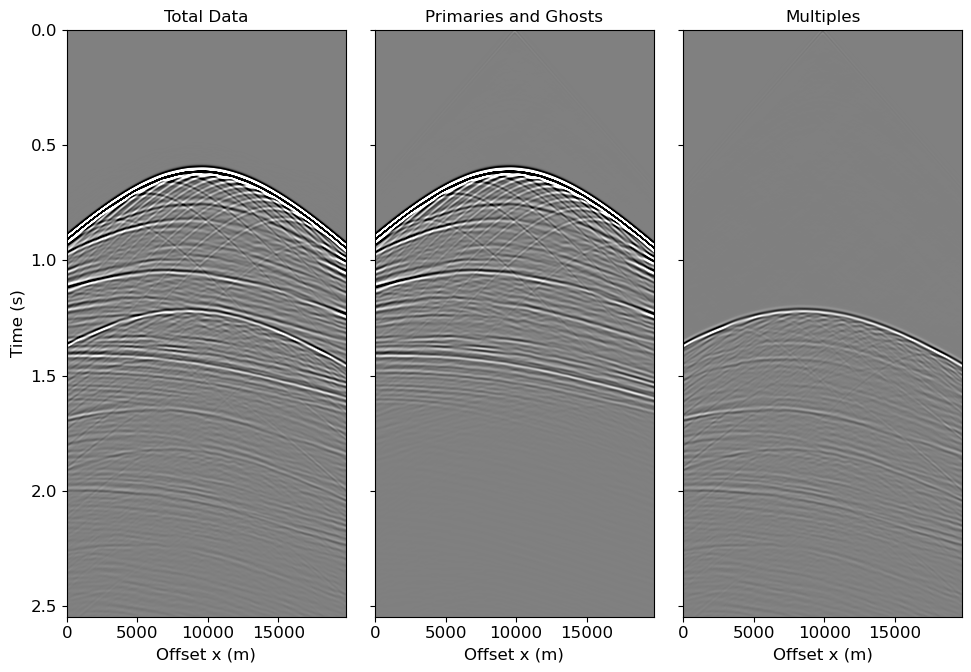

In [20]:
# Visualize data
t0 = 0
t1 = t0 + (nt - 1)*dt
xmin = 0
xmax = nr*dx

vmax = 1e-2 
vmin = -vmax

fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)

axs[0].imshow(data_nodw, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title('Total Data',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[1].imshow(p_nodw, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title('Primaries and Ghosts',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)
axs[2].imshow(multiples, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title('Multiples',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=12)
axs[2].tick_params(axis='x', labelsize=12)

plt.tight_layout()

## Solve all shots

Finally we model for all shots and save them as npz files. You can use the **model_data.py** file found in the scripts folder to run this modeling code on the terminal instead, since it takes many hours to complete. The output will be saved in the data folder.

### - Total Data

* Reflections

In [ ]:
# Total data

start_time = time.time()/60

dtot, _ = awe.solve_all_shots(dt=dt, savedtot=True) 

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

* Direct Wave

In [ ]:
# Total data direct wave

start_time = time.time()/60

dw_tot, _ = awe_dw.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

Save array

In [ ]:
# Subtract direct wave
d_nodw_tot = dtot - dw_tot

# Remove samples
d_nodw_tot = d_nodw_tot[:, :, 25:-1]

# Save 3d numpy array
np.savez('../data/data.npz', d_nodw_tot)

### - Primaries

* Reflections

In [ ]:
# p1

start_time = time.time()/60

p1_tot, _ = awe_1.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

In [ ]:
# p2

start_time = time.time()/60

p2_tot, _ = awe_2.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

In [ ]:
# p3

start_time = time.time()/60

p3_tot, _ = awe_3.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

In [ ]:
# p4

start_time = time.time()/60

p4_tot, _ = awe_4.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

* Direct Waves

In [ ]:
# p1 DW

start_time = time.time()/60

dw1_tot, _ = awe_dw1.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

In [ ]:
# p2 DW

start_time = time.time()/60

dw2_tot, _ = awe_dw2.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

In [ ]:
# p3 DW

start_time = time.time()/60

dw3_tot, _ = awe_dw3.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

In [ ]:
# p4 DW

start_time = time.time()/60

dw4_tot, _ = awe_dw4.solve_all_shots(dt=dt, savedtot=True)  

print("--- %s minutes ---" % round((time.time()/60 - start_time), 3))

Save array

In [ ]:
# Subtract direct wave
p_nodw_tot = (p1_tot + p4_tot - p2_tot - p3_tot) - (dw1_tot + dw4_tot - dw2_tot - dw3_tot)

# Remove samples
p_nodw_tot = p_nodw_tot[:, :, 25:-1]

# Save 3d numpy array
np.savez('../data/primaries.npz', p_nodw_tot)

## References

De Jonge, T. (2023). *Machine learning and artificial neural networks for seismic processing* [Doctoral dissertation, University of Bergen].